In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import statsmodels.api as sm

import seaborn as sns
sns.set()

%matplotlib inline
plt.rcParams.update({'font.size': 24})

## USDA

In [26]:
# Read in USDA data
usda = pd.read_csv("../../model_results/output/USDA_county_yields_w_state_trends.csv")
usda["GEOID"] = usda["GEOID"].astype(str).str.zfill(5)
usda.set_index(["GEOID", "year"], inplace = True)

In [11]:
usda.head()

,,state_fips_code,county_code,asd_code,Value,area,Log_value,state_Value,lowess_log_state_Value,target_Value
GEOID,year,,,,,,,,,
01001,1950,1,1,40,17.0,29600.0,2.833213,21.5,3.033747,-0.200534
01011,1950,1,11,40,11.0,24200.0,2.397895,21.5,3.033747,-0.635852
01047,1950,1,47,40,13.0,44200.0,2.564949,21.5,3.033747,-0.468798
01051,1950,1,51,40,23.0,38900.0,3.135494,21.5,3.033747,0.101747
01063,1950,1,63,40,16.0,23900.0,2.772589,21.5,3.033747,-0.261158


In [27]:
# Tidy
del usda["state_fips_code"]
del usda["county_code"]
del usda["asd_code"]
del usda["Log_value"]
del usda["state_Value"]
del usda["lowess_log_state_Value"]
del usda["target_Value"]

In [28]:
# Construct county -> national weights
usda["national_weight"] = usda["area"] * usda["Value"]
usda_norm = usda.groupby("year").sum().drop(columns = ["Value", "area"])

usda = pd.merge(usda.reset_index(), usda_norm.reset_index(), on = "year", how = "outer")

usda["national_weight"] = usda["national_weight_x"] / usda["national_weight_y"]
del usda["national_weight_x"]
del usda["national_weight_y"]

In [37]:
usda.head()

,GEOID,year,Value,area,national_weight
0,01001,1950,17.0,29600.0,0.000129
1,01011,1950,11.0,24200.0,0.000068
2,01047,1950,13.0,44200.0,0.000147
3,01051,1950,23.0,38900.0,0.000230
4,01063,1950,16.0,23900.0,0.000098


In [39]:
# Save weights
usda.to_csv("./usda_county_to_national_weights.csv", index = False)

# GMFD national

In [50]:
# USDA
usda = pd.read_csv("./usda_county_to_national_weights.csv")
usda["GEOID"] = usda["GEOID"].astype(str).str.zfill(5)

In [51]:
# GMFD
gmfd = pd.read_csv("../../model_results/output/yield_historical_gmfd_offset.csv")
gmfd["GEOID"] = gmfd["GEOID"].astype(str).str.zfill(5)

In [45]:
gmfd.head()

projected  projected_offset
GEOID Year                             
01001 1960   0.320877         -0.333677
      1961   0.572987         -0.081567
      1962   0.098347         -0.556207
      1963   0.348475         -0.306078
      1964   0.413410         -0.241144

In [49]:
usda.head()

,,Value,area,national_weight
GEOID,year,,,
01001,1950,17.0,29600.0,0.000129
01011,1950,11.0,24200.0,0.000068
01047,1950,13.0,44200.0,0.000147
01051,1950,23.0,38900.0,0.000230
01063,1950,16.0,23900.0,0.000098


In [56]:
# Merge
gmfd_all = pd.merge(gmfd, usda, left_on = ["GEOID", "Year"], right_on = ["GEOID", "year"], how = "inner")

In [61]:
gmfd_all.head()

,GEOID,Year,projected,projected_offset,year,Value,area,national_weight
0,01001,1960,0.320877,-0.333677,1960,28.0,20100.0,0.000096
1,01001,1961,0.572987,-0.081567,1961,32.0,16700.0,0.000102
2,01001,1962,0.098347,-0.556207,1962,25.0,15450.0,0.000072
3,01001,1963,0.348475,-0.306078,1963,36.0,16000.0,0.000100
4,01001,1964,0.413410,-0.241144,1964,33.0,16100.0,0.000112


In [ ]:
# WHAT is happening here?

In [63]:
len(usda.drop_duplicates())

301359

In [66]:
len(usda)

316210

In [64]:
len(gmfd.drop_duplicates())

177555

In [65]:
len(gmfd)

177555

In [67]:
len(gmfd_all)

268186

In [68]:
len(gmfd_all.drop_duplicates())

254727

In [69]:
# Calculate weighted yields
gmfd_all["projected_offset_nationally_weighted"] = gmfd_all["projected_offset"] * gmfd_all["national_weight"]

In [73]:
# Per year
gmfd_national = gmfd_all.groupby("Year").sum().drop(columns = "year")

In [74]:
gmfd_national.head()

,projected,projected_offset,Value,area,national_weight,projected_offset_nationally_weighted
Year,,,,,,
1960,1594.570343,-2340.695796,156352.8,1.038851e+08,0.999999,0.012570
1961,1710.213295,-2233.264145,173824.6,8.460654e+07,0.999999,-0.051317
1962,1604.371170,-2308.684447,177632.2,8.109913e+07,0.999998,0.048265
1963,1548.736005,-2677.439912,196031.5,8.617302e+07,0.999998,-0.047210
1964,1388.751060,-2533.914690,173975.5,7.634698e+07,0.999999,-0.101288


In [76]:
# Read in USDA trends
usda_trends = pd.read_csv("../../model_results/output/USDA_county_yields_w_state_trends.csv")
usda_trends["GEOID"] = usda["GEOID"].astype(str).str.zfill(5)

In [77]:
usda_trends.head()

,GEOID,year,state_fips_code,county_code,asd_code,Value,area,Log_value,state_Value,lowess_log_state_Value,target_Value
0,01001,1950,1,1,40,17.0,29600.0,2.833213,21.5,3.033747,-0.200534
1,01011,1950,1,11,40,11.0,24200.0,2.397895,21.5,3.033747,-0.635852
2,01047,1950,1,47,40,13.0,44200.0,2.564949,21.5,3.033747,-0.468798
3,01051,1950,1,51,40,23.0,38900.0,3.135494,21.5,3.033747,0.101747
4,01063,1950,1,63,40,16.0,23900.0,2.772589,21.5,3.033747,-0.261158


In [88]:
# Read in USDA national level
usda_national = pd.read_csv("../../usda_yields/output/USDA_national_yields.csv")

In [90]:
# Do lowess filter
lowess = sm.nonparametric.lowess
usda_national["lowess_log_Value"] = 0.0
    
lws_filter = lowess(usda_national["log_Value"], usda_national["year"], missing = "drop")
    
temp = pd.DataFrame(data = {"lowess_log_Value_x" : pd.Series(lws_filter[:,1], index = lws_filter[:,0].astype(int))})
temp.index.names = ["year"]
usda_national = pd.merge(usda_national, temp.reset_index(), on = ["year"], how = "outer")
usda_national = usda_national.fillna(0)
usda_national["lowess_log_Value"] = usda_national["lowess_log_Value"] + usda_national["lowess_log_Value_x"]
del usda_national["lowess_log_Value_x"]

In [121]:
usda_national.head()

,Value,state_alpha,state_fips_code,state_name,year,log_Value,lowess_log_Value
0,168.4,US,99,US TOTAL,2019,5.126342,5.174219
1,176.4,US,99,US TOTAL,2018,5.172754,5.160152
2,176.6,US,99,US TOTAL,2017,5.173887,5.146076
3,174.6,US,99,US TOTAL,2016,5.162498,5.131995
4,168.4,US,99,US TOTAL,2015,5.126342,5.117907


In [123]:
usda_national.query("year <= 2016 and year >= 1960")["lowess_log_Value"].values[::-1]

array([4.0110403 , 4.04433639, 4.07749478, 4.11053264, 4.1434673 ,
       4.17631683, 4.20910264, 4.2418477 , 4.27457489, 4.30729882,
       4.33999963, 4.37254669, 4.40454697, 4.43149713, 4.45725124,
       4.48176932, 4.50505275, 4.5271668 , 4.54821582, 4.56832367,
       4.58760803, 4.60616823, 4.62412317, 4.64162421, 4.65879494,
       4.67571748, 4.69245564, 4.70906792, 4.72561183, 4.74207312,
       4.75839556, 4.77449135, 4.79028751, 4.80575392, 4.82089472,
       4.83569394, 4.85014635, 4.86431251, 4.87827546, 4.8922563 ,
       4.90625825, 4.92028336, 4.93433134, 4.94840123, 4.96249346,
       4.97660687, 4.990737  , 5.00487875, 5.01902726, 5.03317799,
       5.04732627, 5.06146657, 5.07559473, 5.08970954, 5.10381283,
       5.11790737, 5.13199489])

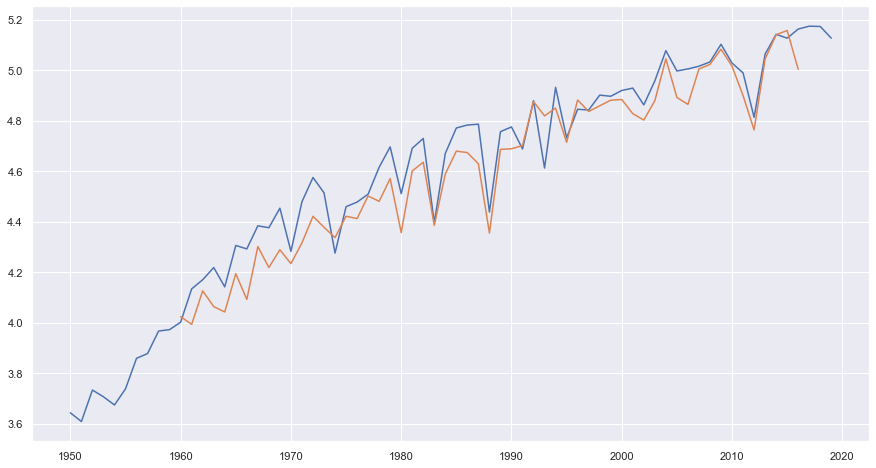

In [127]:
# Plot
fig, ax = plt.subplots(1,1, figsize = (15,8))
plt.plot(usda_national["year"], usda_national["log_Value"])
plt.plot(gmfd_national.reset_index()["Year"].values, usda_national.query("year >= 1960 and year <= 2016")["lowess_log_Value"].values[::-1] + gmfd_national.reset_index()["projected_offset_nationally_weighted"].values)
plt.show()